In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import spdiags
import scipy as sp
from sympy import *
from sympy.physics.wigner import wigner_3j
import pandas as pd
import csv
import re
import flt #Fast Legendre Transform

In [13]:
def SR_orbitals(dx,xMin,xMax,M,a,m,lmax,omega0):

    lList  = list(range(abs(m),lmax))
    Lambda = [x * (x + 1) for x in lList]
    
    rp,rm = M + (M**2 - a**2)**0.5,M - (M**2 - a**2)**0.5

    omegaH = a * m / (2 * M * rp); #Angular frequency of the horizon
    
    x = np.array(range(int(xMin/dx),int(xMax/dx) + 1)) * dx
    xLeft,xRight  = x + dx, x - dx
    
    r,rLeft,rRight = rp * (sp.special.lambertw(np.exp(x)) + 1),rp * (sp.special.lambertw(np.exp(xLeft)) + 1),rp * (sp.special.lambertw(np.exp(xRight)) + 1)


    density_data = np.zeros([11,len(x)],dtype = 'complex_')
    density_profile_names = ['00','01','02','03','04','05','06','07','08','09','10'];
    for ii in range(11):
        data = list(csv.reader(open('kerr_density_profile/densityh_08_'+density_profile_names[ii]+'.dat')))
        data = [re.split('\t', x[0]) for x in data]
        data = np.array(list(zip(*data))[:2])
        data = data.astype(float)
        interpolation = sp.interpolate.Akima1DInterpolator(data[0],(data[1]/(10**18))**4)
        density_data[ii] = np.array([np.array([max(interpolation(rr),0) for rr in r])])
    density_data = np.nan_to_num(density_data, nan=0)
    # mu2_pre = np.zeros([11,len(x)],dtype = 'complex_')
    # for jj in range(len(x)):
    #     mu2_pre[:,jj] = flt.dlt(np.real(density_data[:,jj]),closed = True)/np.array([np.sqrt(4 * np.pi/(2 * l + 1)) for l in range(11)])
    # mu2 = [mu2_pre[i] * 10**1 for i in range(10)]

    nn = 21
    mu2_pre = np.zeros([nn,len(x)],dtype = 'complex_')
    for jj in range(len(x)):
        pts = np.linspace(-1,1,nn)
        ddraw = density_data[:,jj]
        ddmirror = np.flip(ddraw)[:-1]
        dd = np.concatenate((ddmirror,ddraw))
        ddint = sp.interpolate.Akima1DInterpolator(np.linspace(-1,1,21),np.real(dd))
        mu2_pre[:,jj] = flt.dlt(ddint(pts),closed = True)*np.array([np.sqrt(4 * np.pi/(2 * l + 1)) for l in range(nn)])
    mu2 = mu2_pre
    
    N = len(x)
    Nharmonics = len(lList)
    NMassHarmonics = len(mu2_pre)

    mask = np.ones(N)
    mask[0] = 0
    mask[-1] = 0


    alpha = np.zeros([Nharmonics,Nharmonics],dtype = 'complex_')
    beta  = np.zeros([Nharmonics,Nharmonics,N],dtype = 'complex_')
    gamma = np.zeros([Nharmonics,Nharmonics,N],dtype = 'complex_')
    delta = np.zeros([Nharmonics,Nharmonics],dtype = 'complex_')
    for dl1 in range(Nharmonics):
        for dl2 in range(Nharmonics):
            l = m + dl1
            lp = m + dl2
            alpha[dl1,dl2] = (-1)**m * (1/3) * np.sqrt((2 * l + 1) * (2 * lp + 1)) * (float(wigner_3j(lp,0,l,-m,0,m)) * float(wigner_3j(lp,0,l,0,0,0)) + 2 * float(wigner_3j(lp,2,l,-m,0,m)) * float(wigner_3j(lp,2,l,0,0,0)))
            delta[dl1,dl2] = (l == lp)
            for dl3 in range(NMassHarmonics):
                lpp = dl3
                beta[dl1,dl2] += np.sqrt(4 * np.pi) * (-1)**m * mu2[dl3] * np.sqrt((2*l+1)*(2*lp+1)*(2*lpp+1)/(4 * np.pi)) * float(wigner_3j(l,lp,lpp,m,-m,0)) * float(wigner_3j(l,lp,lpp,0,0,0))
                for lppp in range(10 * (Nharmonics + NMassHarmonics + abs(m) + l)):
                    gamma[dl1,dl2] += np.sqrt(4 * np.pi) * (1/3)*(-1)**(m)*mu2[dl3]*np.sqrt((2*l+1)*(2*lp+1)*(2*lpp+1)*(2*lppp+1)**2 / np.pi)*float(wigner_3j(l,lp,lppp,m,-m,0))*float(wigner_3j(l,lp,lppp,0,0,0))*float(wigner_3j(lpp,lppp,2,0,0,0))**2
            gamma[dl1,dl2] += (1/3)*beta[dl1,dl2]

    
    HElements,HElementsLeft,HElementsRight =  (r - rp)/(r - rm),(rLeft - rp)/(rLeft - rm),(rRight - rp)/(rRight - rm)
    Vt0Elements = np.zeros([Nharmonics,Nharmonics,N],dtype = 'complex_')
    Vt1Elements = np.zeros([Nharmonics,Nharmonics,N],dtype = 'complex_')
    Vt2Elements = np.zeros([Nharmonics,Nharmonics,N],dtype = 'complex_')
    DElements   = np.zeros([Nharmonics,Nharmonics,3,N],dtype = 'complex_')

    B0               = 1 + dx * omegaH * 2 * 1j * (rp/(rp - rm))
    B1               =            - dx * 2 * 1j * (rp/(rp - rm))
    B2               =            + dx * 1 * 1j * (rp)

    DLeft   = np.array((1/(dx**2) - (a**2/rLeft**2) * HElementsLeft/(2 * dx)),dtype = 'complex_')
    DMiddle = np.array((-2 /(dx**2)) + 0 * mask,dtype = 'complex_')
    DRight  = np.roll(np.array((1/(dx**2) + (a**2/rRight**2) * HElementsRight/(2 * dx)),dtype = 'complex_'),1)
    DMiddle[0] = B0
    DRight[1] = -1
    DMiddle[-1] = -1
    DLeft[-2] = 1
    
    for idx1 in range(Nharmonics): 
        for idx2 in range(Nharmonics):
            Vt0Elements[idx1,idx2] = np.array(((m**2 * a**2) /((r - rm) ** 2) - HElements * ( Lambda[idx1]) 
                                               + HElements * (2 / r**2) * (a**2 - M * r)) * delta[idx1,idx2]
                                              +(- HElements * (r**2)) * beta[idx1,idx2] 
                                              - HElements * a**2 * gamma[idx1,idx2],dtype = 'complex_') * mask * (rp/r)**2
            Vt1Elements[idx1,idx2] = np.array(-(4 * M * a * m * r) /((r - rm)**2) * delta[idx1,idx2],dtype = 'complex_') * mask * (rp/r)**2
            Vt2Elements[idx1,idx2] = np.array((((r**2 +  a**2)**2) /((r - rm)**2) - HElements * a**2) * delta[idx1,idx2] 
                                              + HElements * a**2 * alpha[idx1,idx2],dtype = 'complex_') * mask * (rp/r)**2
            Vt1Elements[idx1,idx2,0] = B1 * delta[idx1,idx2]
            Vt1Elements[idx1,idx2,-1] = B2 * delta[idx1,idx2]
            DElements[idx1,idx2] = np.array([DLeft,DMiddle,DRight],dtype = 'complex_') * delta[idx1,idx2]

    D2 = sp.sparse.bmat([[spdiags(DElements[idx1,idx2],[-1,0,1],N,N) for idx1 in range(Nharmonics)] for idx2 in range(Nharmonics)])
    Vt0 = sp.sparse.bmat([[spdiags(Vt0Elements[idx1,idx2],[0],N,N) for idx1 in range(Nharmonics)] for idx2 in range(Nharmonics)])
    Vt1 = sp.sparse.bmat([[spdiags(Vt1Elements[idx1,idx2],[0],N,N) for idx1 in range(Nharmonics)] for idx2 in range(Nharmonics)])
    Vt2 = sp.sparse.bmat([[spdiags(Vt2Elements[idx1,idx2],[0],N,N) for idx1 in range(Nharmonics)] for idx2 in range(Nharmonics)])

    Id,Z = spdiags(np.ones(N * Nharmonics),0,N * Nharmonics,N * Nharmonics),spdiags(np.zeros(N * Nharmonics),0,N * Nharmonics,N * Nharmonics)
    
    A11 = D2 + Vt0;
    A12 = Vt1 + omega0 * Vt2;
    A21 = Id * omega0;
    A22 = Id * (-1);
    
    B11 = Z
    B12 = Vt2
    B21 = Id
    B22 = Z
    
    A = sp.sparse.bmat([[A11,A12],[A21,A22]])
    B = sp.sparse.bmat([[B11,B12],[B21,B22]])

    evals,evectors = sp.sparse.linalg.eigs(A,k = 1,M = B, sigma = 0)
    return r,x,evals,evectors,Nharmonics,mu2

[0.00297181+2.60546425e-10j]


/var/folders/bj/2sxxmcw51675p0sgmwt6jctr0000gn/T/ipykernel_83254/3596543638.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(x,np.log(mu2[0]))


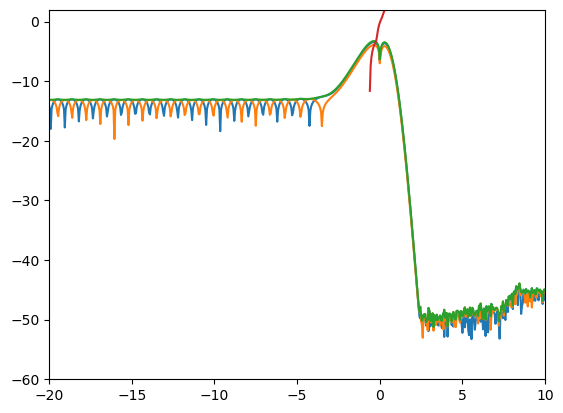

In [24]:
#dx,xMin,xMax,M,a,mu,n,l,m,lmax,omega0
#Normalization = 10^17, 1.2 * 
l = 30
omegaGuess = 8.88
r,x,evals,evectors,Nharmonics,mu2 = SR_orbitals(0.05,-200,10,1,0.80,l,l+1,omegaGuess)
print(evals)
ax = plt.axes() 

for zz in range(0,Nharmonics,1):
    plt.plot(x,np.log(np.abs(np.real(evectors[zz * len(evectors)//(2 * Nharmonics):(zz + 1) * len(evectors)//(2 * Nharmonics)]))))
    plt.plot(x,np.log(np.abs(np.imag(evectors[zz * len(evectors)//(2 * Nharmonics):(zz + 1) * len(evectors)//(2 * Nharmonics)]))))
    plt.plot(x,np.log(np.abs(np.abs(evectors[zz * len(evectors)//(2 * Nharmonics):(zz + 1) * len(evectors)//(2 * Nharmonics)]))))
    plt.plot(x,np.log(mu2[0]))
    plt.ylim(-60,2)
    plt.xlim(-20,10)

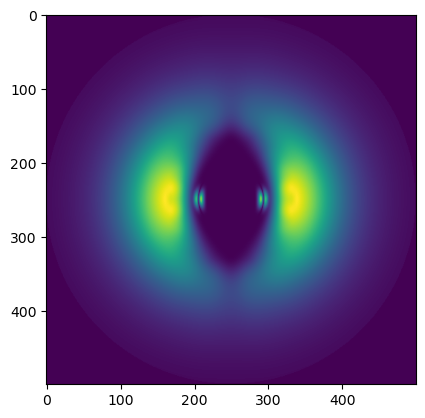

In [42]:
gridr = np.linspace(-r[-1],r[-1],500)
xc,yc = np.real(np.meshgrid(np.real(gridr),np.real(gridr)))
i0 = 3400
evInt = [sp.interpolate.Akima1DInterpolator(np.real(r[i0:]),np.real(evectors[zz * len(evectors)//(2 * Nharmonics) + i0:(zz + 1) * len(evectors)//(2 * Nharmonics)])) for zz in range(Nharmonics)]
mu2Int = [sp.interpolate.Akima1DInterpolator(np.real(r[i0:]),np.real(mu2[zz][i0:])) for zz in range(21)]

val = 0 * xc
mu2val = 0 * xc
for zz in range(Nharmonics):
    val += np.nan_to_num(np.real(np.squeeze(evInt[zz](np.sqrt(xc**2 + yc**2)))*(sp.special.sph_harm(l,l+zz,0,np.arctan2(xc,yc)))))
for qq in range(21):
    mu2val += np.nan_to_num(np.real(np.squeeze(mu2Int[qq](np.sqrt(xc**2 + yc**2)))*sp.special.sph_harm(0, qq,0,np.arctan2(xc,yc))))
plt.imshow(np.abs(val)*10**4+np.abs(mu2val))